In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers,models
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras import models, layers, optimizers
import warnings
warnings.simplefilter("ignore")
from PIL import Image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [29]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow as tf

class LivePlotCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(LivePlotCallback, self).__init__()
        self.epochs = []
        self.history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

    def on_epoch_end(self, epoch, logs=None):
        self.epochs.append(epoch)
        self.history['accuracy'].append(logs.get('accuracy'))
        self.history['val_accuracy'].append(logs.get('val_accuracy'))
        self.history['loss'].append(logs.get('loss'))
        self.history['val_loss'].append(logs.get('val_loss'))

        clear_output(wait=True)
        self.plot_metrics()

    def plot_metrics(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        ax1.plot(self.epochs, self.history['accuracy'], label='Train Accuracy')
        ax1.plot(self.epochs, self.history['val_accuracy'], label='Validation Accuracy')
        ax1.set_title('Accuracy over epochs')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Accuracy')
        ax1.legend()

        ax2.plot(self.epochs, self.history['loss'], label='Train Loss')
        ax2.plot(self.epochs, self.history['val_loss'], label='Validation Loss')
        ax2.set_title('Loss over epochs')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Loss')
        ax2.legend()

        plt.show()


In [30]:
# Mixed precision training
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

In [31]:
import os
print(len(os.listdir('E:/Call of Duty/cassava-leaf-disease-classification/train_images')))

0


In [32]:
print(len(os.listdir("E:/Call of Duty/cassava-leaf-disease-classification/test_images")))

1


In [33]:
import pandas as pd
train_df = pd.read_csv("E:/Call of Duty/cassava-leaf-disease-classification/train.csv")
train_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


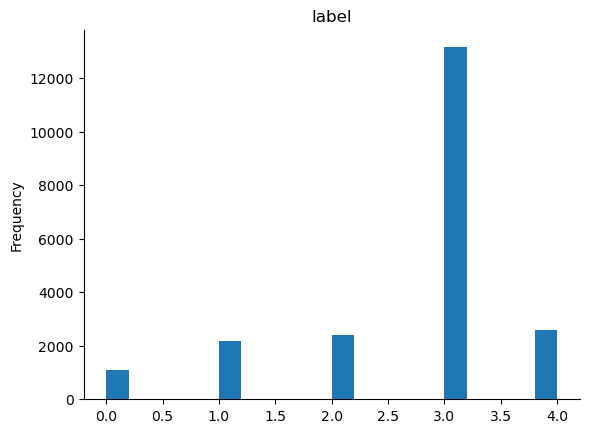

In [34]:
# @title label

from matplotlib import pyplot as plt
train_df['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [35]:
train_df['label'].value_counts()

label
3    13158
4     2577
2     2386
1     2189
0     1087
Name: count, dtype: int64

In [36]:
import json
with open("E:/Call of Duty/cassava-leaf-disease-classification/label_num_to_disease_map.json") as file:
    print(json.dumps(json.loads(file.read()), indent=4))

{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


In [37]:
y_pred = [3] * len(train_df.label)
print("The baseline accuracy is {}".format(accuracy_score(y_pred, train_df.label)))

The baseline accuracy is 0.6149460204701593


In [38]:
batch_size = 32  # Reduced batch size
IMG_SIZE = (128, 128)  # Reduced image size

In [ ]:
import os
import shutil
import pandas as pd

# Define the paths
image_folder = 'E:/Call of Duty/cassava-leaf-disease-classification/train_images'
csv_file ="E:/Call of Duty/cassava-leaf-disease-classification/train.csv"
output_folder = "E:/Call of Duty/cassava-leaf-disease-classification/train_ds"
# Read the CSV file
df = pd.read_csv(csv_file)

# Ensure the output directory exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Iterate over the rows in the DataFrame
for index, row in df.iterrows():
    image_id = str(row['image_id'])  # Ensure image_id is a string
    if not image_id.endswith('.jpg'):
        image_name = f"{image_id}.jpg"  # Add extension if not present
    else:
        image_name = image_id  # Use as is if extension is present

    label = row['label']  # Assuming label is a column in the CSV

    # Create the label directory if it doesn't exist
    label_dir = os.path.join(output_folder, str(label))
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)

    # Define source and destination paths
    src_path = os.path.join(image_folder, image_name)
    dst_path = os.path.join(label_dir, image_name)

    # Move the file
    if os.path.exists(src_path):
        shutil.move(src_path, dst_path)
    else:
        print(f"File {src_path} does not exist and cannot be moved.")

print("Images have been organized into subfolders by class.")


In [40]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  output_folder,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=batch_size)

Found 21397 files belonging to 5 classes.
Using 17118 files for training.


In [41]:
val_ds = tf.keras.utils.image_dataset_from_directory(
output_folder,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=batch_size)

Found 21397 files belonging to 5 classes.
Using 4279 files for validation.


In [42]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [43]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4']


In [44]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [45]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [46]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [47]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 4, 4, 1280)


In [48]:
base_model.trainable = False

In [49]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [50]:
prediction_layer = tf.keras.layers.Dense(5, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


In [51]:
inputs = tf.keras.Input(shape=(128, 128, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Increased dropout rate
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [52]:
base_learning_rate = 0.001  # Adjusted learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [53]:
# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model.keras", monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
live_plot = LivePlotCallback()

In [54]:
total_samples = len(train_df)
class_weights = {0: total_samples / train_df['label'].value_counts()[0],
                 1: total_samples / train_df['label'].value_counts()[1],
                 2: total_samples / train_df['label'].value_counts()[2],
                 3: total_samples / train_df['label'].value_counts()[3],
                 4: total_samples / train_df['label'].value_counts()[4]}


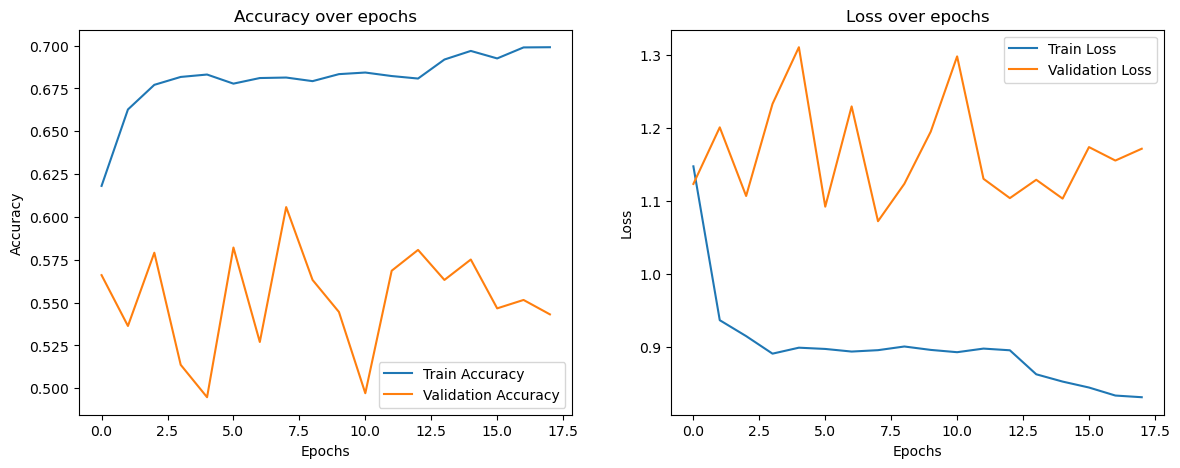

535/535 ━━━━━━━━━━━━━━━━━━━━ 290s 542ms/step - accuracy: 0.7038 - loss: 0.8204 - val_accuracy: 0.5431 - val_loss: 1.1716 - learning_rate: 2.0000e-04


In [55]:
history = model.fit(train_ds,
                    epochs=50,  # Increased epochs
                    validation_data=val_ds,
                    #class_weight=class_weights,
                    callbacks=[checkpoint, early_stopping, reduce_lr,live_plot ])